In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Load dataset
data = pd.read_csv('preprocessed.csv')

# Encode categorical columns
data['RainToday'] = LabelEncoder().fit_transform(data['RainToday'])
data['RainTomorrow'] = LabelEncoder().fit_transform(data['RainTomorrow'])

In [3]:
# Features and Target
X = data.drop(columns=['RainTomorrow'])
y = data['RainTomorrow']

In [4]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


X.shape

(145460, 22)

In [5]:
# ANN Model Architecture
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,\
    
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

C:\Users\anura\.conda\envs\py312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2910/2910 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8011 - loss: 0.4451 - val_accuracy: 0.8483 - val_loss: 0.3540 - learning_rate: 0.0010
Epoch 2/100
2910/2910 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8366 - loss: 0.3769 - val_accuracy: 0.8479 - val_loss: 0.3535 - learning_rate: 0.0010
Epoch 3/100
2910/2910 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8402 - loss: 0.3651 - val_accuracy: 0.8491 - val_loss: 0.3496 - learning_rate: 0.0010
Epoch 4/100
2910/2910 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8406 - loss: 0.3669 - val_accuracy: 0.8493 - val_loss: 0.3475 - learning_rate: 0.0010
Epoch 5/100
2910/2910 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8437 - loss: 0.3627 - val_accuracy: 0.8498 - val_loss: 0.3449 - learning_rate: 0.0010
Epoch 6/100
2910/2910 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8434 - loss: 0.3632 - val_accuracy: 0.8512 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 7/100
2910/2910 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy:

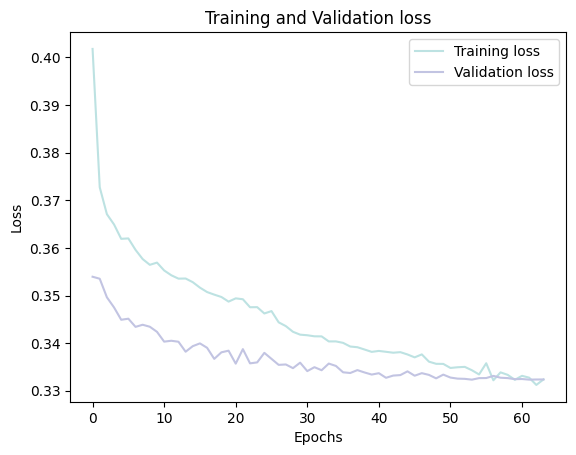

In [6]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

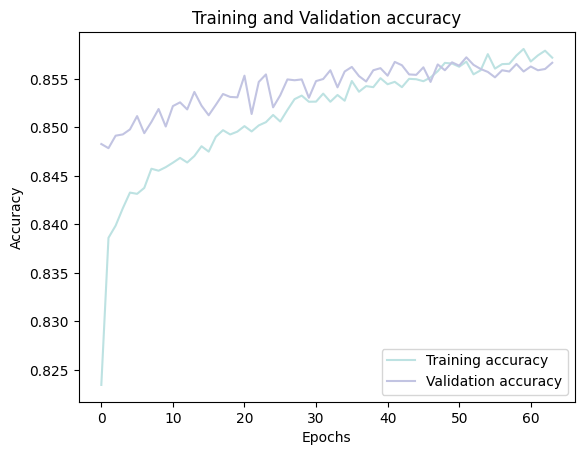

In [7]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
# Evaluate on test set
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))

910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step  
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22717
           1       0.74      0.54      0.62      6375

    accuracy                           0.86     29092
   macro avg       0.81      0.74      0.77     29092
weighted avg       0.85      0.86      0.85     29092



910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step


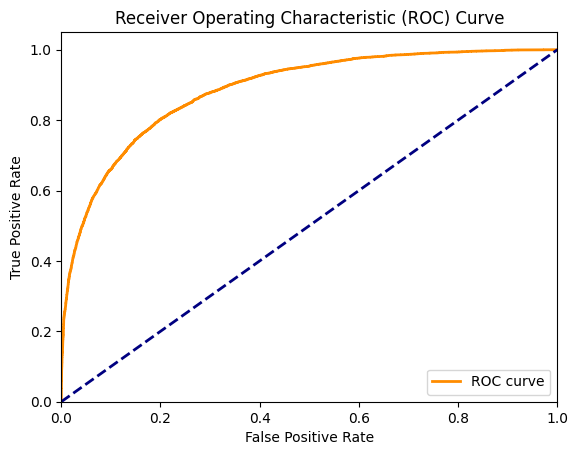

AUC: 0.8856007360817284


In [9]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

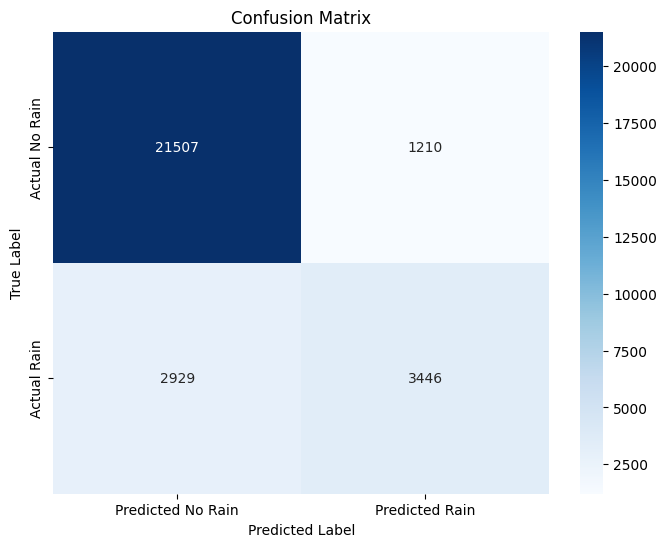

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Rain', 'Predicted Rain'],
            yticklabels=['Actual No Rain', 'Actual Rain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()